In [2]:
import math
import torch
from torch import Tensor
from torch import nn
import torch.nn.functional as F
from typing import Optional, List
import torchvision.transforms as transforms
from PIL import Image
from torchvision.models import resnet50,ResNet50_Weights
from torch import Tensor
from matplotlib import cm
from torchvision.transforms.functional import to_pil_image
import os  

In [3]:
def process_image_withhooks(img_path, model_weights=ResNet50_Weights.DEFAULT):  
    """  
    处理图片并计算特征和梯度的加权值donations_values  

    Args:  
        img_path (str): 输入图片的路径  
        model_weights: 模型的预训练权重，默认为ResNet50的默认权重  

    Returns:  
        tensor: shape (num_classes,) 的 tensor，表示各个类别的donations_values  
    """  
    # 定义预处理步骤  
    test_transform = transforms.Compose([  
        transforms.Resize(512),  
        transforms.ToTensor(),  
        transforms.Normalize(  
            mean=[0.485, 0.456, 0.406],  
            std=[0.229, 0.224, 0.225]  
        )  
    ])  

    # 获取设备  
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')  

    # 初始化模型  
    model = resnet50(weights=model_weights).eval().to(device)  

    # print(f"try to open image, path：{img_path}")  
    if not img_path.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):  
        print(f"跳过非图片文件：{img_path}")  
        return None  

    # 加载图片  
    img_pil = Image.open(img_path)  

    # 预处理图片  
    input_tensor = test_transform(img_pil).unsqueeze(0).to(device)  

    # 定义前向hook  
    def forward_hook(module, inp, outp):  
        feature_map.append(outp)  

    # 定义反向hook  
    def backward_hook(module, inp, outp):  
        grad.append(outp)  

    # 初始化容器  
    feature_map = []  
    grad = []  

    # 注册hook  
    hook_layer = model.layer4[-1]  
    hook_handle = hook_layer.register_forward_hook(forward_hook)  
    grad_hook_handle = hook_layer.register_full_backward_hook(backward_hook)  

    try:  
        # 前向传播  
      
        out = model(input_tensor)  
        cls_idx = torch.argmax(out).item()  
        # 计算预测类别分数  
        score = out[:, cls_idx].sum()  

        # 反向传播  
        model.zero_grad()  
        score.backward(retain_graph=False)  # 减少内存占用  

        # 获取特征和梯度  
        weights = grad[0][0].squeeze(0).mean(dim=(1, 2))  
        mean_values = feature_map[0].squeeze(0).mean(dim=(1, 2))  #GAP(a)

        # 计算weights的绝对值  
        abs_weights = torch.abs(weights)  
        
        # 找到绝对值最大的10%的channel的索引  
        num_channels = len(weights)  
        top_k = int(num_channels * 0.1)  
        _, top_indices = torch.topk(abs_weights, top_k)  

         # 创建全零的张量  
        selected_mean_values = torch.zeros_like(mean_values) 
        selected_weights = torch.zeros_like(weights)
        
        # 将选中的值复制到相应的位置  
        selected_mean_values[top_indices] = mean_values[top_indices] 
        selected_weights[top_indices] =  weights[top_indices]

        # 取绝对值
        selected_mean_values = torch.abs(selected_mean_values)
        selected_weights = torch.abs(selected_weights)
        
        return selected_mean_values.detach().cpu(),selected_weights.detach().cpu()
         

    except Exception as e:  
        print(f"处理过程中出现错误：{e}")  
        return None  

    finally:  
        # 删除hook并清理数据  
        hook_handle.remove()  
        grad_hook_handle.remove()  
        feature_map.clear()  
        grad.clear()  

        # 删除GPU上的张量并释放内存  
        if input_tensor.is_cuda:  
            del input_tensor  
            torch.cuda.empty_cache()  

        if 'out' in locals():  
            del out  
        if 'score' in locals():  
            del score

In [4]:
img_path="dataset/波斯猫/1.jpg"
selected_mean_values,selected_weights=process_image_withhooks(img_path, model_weights=ResNet50_Weights.DEFAULT)
print(selected_mean_values)
print(selected_weights)
selected_weights.size()

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /home/featurize/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 168MB/s] 


tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([0., 0., 0.,  ..., 0., 0., 0.])


torch.Size([2048])

In [9]:
import numpy as np  
import matplotlib.pyplot as plt  
import torch  
import random  
from typing import List  

def visualize_tensor(tensor_2048d: torch.Tensor, title: str = "2048D Tensor Visualization", color: str = 'skyblue') -> None:  
    """  
    将一个2048维的PyTorch张量可视化为柱状图。  
    
    Args:  
        tensor_2048d (torch.Tensor): 形状为 (2048,) 的张量。  
        title (str, optional): 图表标题. Defaults to "2048D Tensor Visualization".  
        color (str, optional): 柱状图颜色，默认为'skyblue'。  
    """  
    tensor_np = tensor_2048d.detach().cpu().numpy()  
    indices = np.arange(tensor_np.size)  
    
    plt.bar(indices, tensor_np, color=color, edgecolor='black', linewidth=0.3)  
    plt.title(title)  
    plt.xlabel('Index')  
    plt.ylabel('Value')  
    
    plt.tick_params(axis='x', labelsize=6)  
    plt.tick_params(axis='y', labelsize=8)  
    
    plt.xticks(rotation=45, ha='right')  
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)  

# def visualize_multiple_tensors(donations_values_list: List[torch.Tensor], title_prefix: str = "Tensor", seed: int = None) -> bool:  
#     """  
#     从一个包含多个2048维PyTorch张量的列表中随机选择4个，并进行可视化。   

#     将所有图像上下拼接在一起展示。  

#     Args:  
#         donations_values_list (list): 包含多个形状为 (2048,) 的PyTorch张量的列表。  
#         title_prefix (str, optional): 图表标题的前缀. Defaults to "Tensor".  
#         seed (int, optional): 随机种子. Defaults to None.  
    
#     Returns:  
#         bool: 成功可视化返回True，否则返回False。  
#     """  
#     if not isinstance(donations_values_list, list) or len(donations_values_list) == 0:  
#         print("输入必须是一个非空列表。")  
#         return False  
    
#     # 设置随机种子  
#     if seed is not None:  
#         random.seed(seed)  
    
#     # 确保所有元素都是PyTorch张量  
#     for idx, tensor in enumerate(donations_values_list):  
#         if not isinstance(tensor, torch.Tensor) or tensor.shape != (2048,):  
#             print(f"索引 {idx} 的张量形状不正确，必须为(2048,)。")  
#             return False  
    
#     # 随机选择4个张量的索引  
#     num_to_select = min(4, len(donations_values_list))  
#     selected_indices = random.sample(range(len(donations_values_list)), num_to_select)  
#     selected_tensors = [donations_values_list[i] for i in selected_indices]  
    
#     # 创建画布以拼接图像  
#     fig, axes = plt.subplots(num_to_select, 1, figsize=(20, 15))  # 使用 4 行 1 列的布局  
    
#     # 遍历选中的张量并进行可视化  
#     for idx, tensor in enumerate(selected_tensors):  
#         title = f"{title_prefix} {selected_indices[idx]}"  
#         # 在对应的子图上绘制  
#         axes[idx].bar(np.arange(tensor.size(0)), tensor.detach().cpu().numpy(), color='skyblue', edgecolor='black', linewidth=0.3)  
#         axes[idx].set_title(title)  
#         axes[idx].set_xlabel('Index')  
#         axes[idx].set_ylabel('Value')  
#         axes[idx].grid(axis='y', linestyle='--', alpha=0.7)  

#     plt.tight_layout()  
#     plt.show()  
#     print(f"成功可视化了 {num_to_select} 个张量。")  
#     return True

def visualize_multiple_tensors(donations_values_list: List[torch.Tensor], 
                                title_prefix: str = "Tensor", 
                                seed: int = None, 
                                threshold_ratio: float = 0.05) -> bool:  
    """  
    从一个包含多个2048维PyTorch张量的列表中随机选择4个，并进行可视化。   
    将所有图像上下拼接在一起展示，并根据阈值改变柱状图颜色。

    Args:  
        donations_values_list (list): 包含多个形状为 (2048,) 的PyTorch张量的列表。  
        title_prefix (str, optional): 图表标题的前缀. Defaults to "Tensor".  
        seed (int, optional): 随机种子. Defaults to None.
        threshold_ratio (float, optional): 阈值比例，相对于张量最大值. Defaults to 0.05.
    
    Returns:  
        bool: 成功可视化返回True，否则返回False。  
    """  
    if not isinstance(donations_values_list, list) or len(donations_values_list) == 0:  
        print("输入必须是一个非空列表。")  
        return False  
    
    # 设置随机种子  
    if seed is not None:  
        random.seed(seed)  
    
    # 确保所有元素都是PyTorch张量  
    for idx, tensor in enumerate(donations_values_list):  
        if not isinstance(tensor, torch.Tensor) or tensor.shape != (2048,):  
            print(f"索引 {idx} 的张量形状不正确，必须为(2048,)。")  
            return False  
    
    # 随机选择4个张量的索引  
    num_to_select = min(4, len(donations_values_list))  
    selected_indices = random.sample(range(len(donations_values_list)), num_to_select)  
    selected_tensors = [donations_values_list[i] for i in selected_indices]  
    
    # 创建画布以拼接图像  
    fig, axes = plt.subplots(num_to_select, 1, figsize=(20, 15))  
    
    # 遍历选中的张量并进行可视化  
    for idx, tensor in enumerate(selected_tensors):
        # 计算阈值
        # threshold = tensor.max().item() * threshold_ratio
        threshold = tensor.mean() + 2 * tensor.std()  # 均值加两倍标准差

        title = f"{title_prefix} {selected_indices[idx]}"
        
        # 根据阈值选择柱状图颜色
        colors = ['skyblue' if val < threshold else 'red' for val in tensor.detach().cpu().numpy()]
        
        # 在对应的子图上绘制  
        axes[idx].bar(np.arange(tensor.size(0)), tensor.detach().cpu().numpy(), 
                      color=colors, edgecolor='black', linewidth=0.3)
        axes[idx].set_title(title)
        axes[idx].set_xlabel('Index')
        axes[idx].set_ylabel('Value')
        axes[idx].grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()  
    plt.show()  
    print(f"成功可视化了 {num_to_select} 个张量。")  
    return True


In [5]:
import numpy as np  

# 配置PyTorch的内存分配参数，减少内存碎片  
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'  

def process_batch_images(class_path, batch_size=8, device=None):  
    """  
    批量处理一个类别下的所有图片，并返回每张图片的selected_mean_values和selected_weights  

    Args:  
        class_path (str): 类别图片的路径  
        batch_size (int): 批次大小，缺省值为8  
        device (str or torch.device, optional): 设备类型（"cpu" 或 "cuda"），缺省值为None，会自动检测  

    Returns:  
        tuple: 一个包含两个列表的元组，selected_mean_values_list和selected_weights_list  
    """  
    if device is None:  
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  
    print("\nUsing device: " + str(device))  
    print("Analyzing class: " + str(class_path))  

    # 初始化两个空列表，分别存储mean_values和weights  
    selected_mean_values_list = []  
    selected_weights_list = []  

    # 获取图片文件路径列表  
    img_paths = [os.path.join(class_path, f) for f in os.listdir(class_path)  
                 if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]  

    # 计算总批次数  
    total_batches = len(img_paths) // batch_size  
    if len(img_paths) % batch_size != 0:  
        total_batches += 1  

    succeed_img = 0  

    # 分批次处理图片  
    for batch_idx in range(total_batches):  
        start = batch_idx * batch_size  
        end = min((batch_idx + 1) * batch_size, len(img_paths))  
        batch_paths = img_paths[start:end]  

        batch_features_mean = []  
        batch_features_weights = []  

        # 逐张处理图片以减少内存占用  
        for img_path in batch_paths:  
            try:  
                # 使用process_image_withhooks处理图片，返回两个张量  
                donations_values = process_image_withhooks(img_path)  

                if donations_values is not None:  
                    # donations_values是一个包含selected_mean_values和selected_weights的元组  
                    selected_mean_values, selected_weights = donations_values  

                    # 将结果添加到批次结果中  
                    batch_features_mean.append(selected_mean_values)  
                    batch_features_weights.append(selected_weights)  

                    succeed_img += 1  

            except Exception as e:  
                print(f"处理 {img_path} 时发生错误：{str(e)}")  
                continue  

        # 将批次结果添加到总列表中  
        if batch_features_mean:  
            selected_mean_values_list.extend(batch_features_mean)  
        if batch_features_weights:  
            selected_weights_list.extend(batch_features_weights)  

        # 清理批次数据  
        batch_features_mean.clear()  
        batch_features_weights.clear()  

    print(f"处理完成，成功处理了 {succeed_img} 张图片。")  

    return selected_mean_values_list, selected_weights_list  

In [6]:
class_path1="dataset/n02105505/" #匈牙利牧羊犬
class_path2="dataset/n02101006/" #戈登雪达犬
selected_mean_values_list1, selected_weights_list1 = process_batch_images(class_path1)
selected_mean_values_list2, selected_weights_list2 = process_batch_images(class_path2)



Using device: cpu
Analyzing class: dataset/n02105505/
处理完成，成功处理了 100 张图片。

Using device: cpu
Analyzing class: dataset/n02101006/
处理完成，成功处理了 100 张图片。


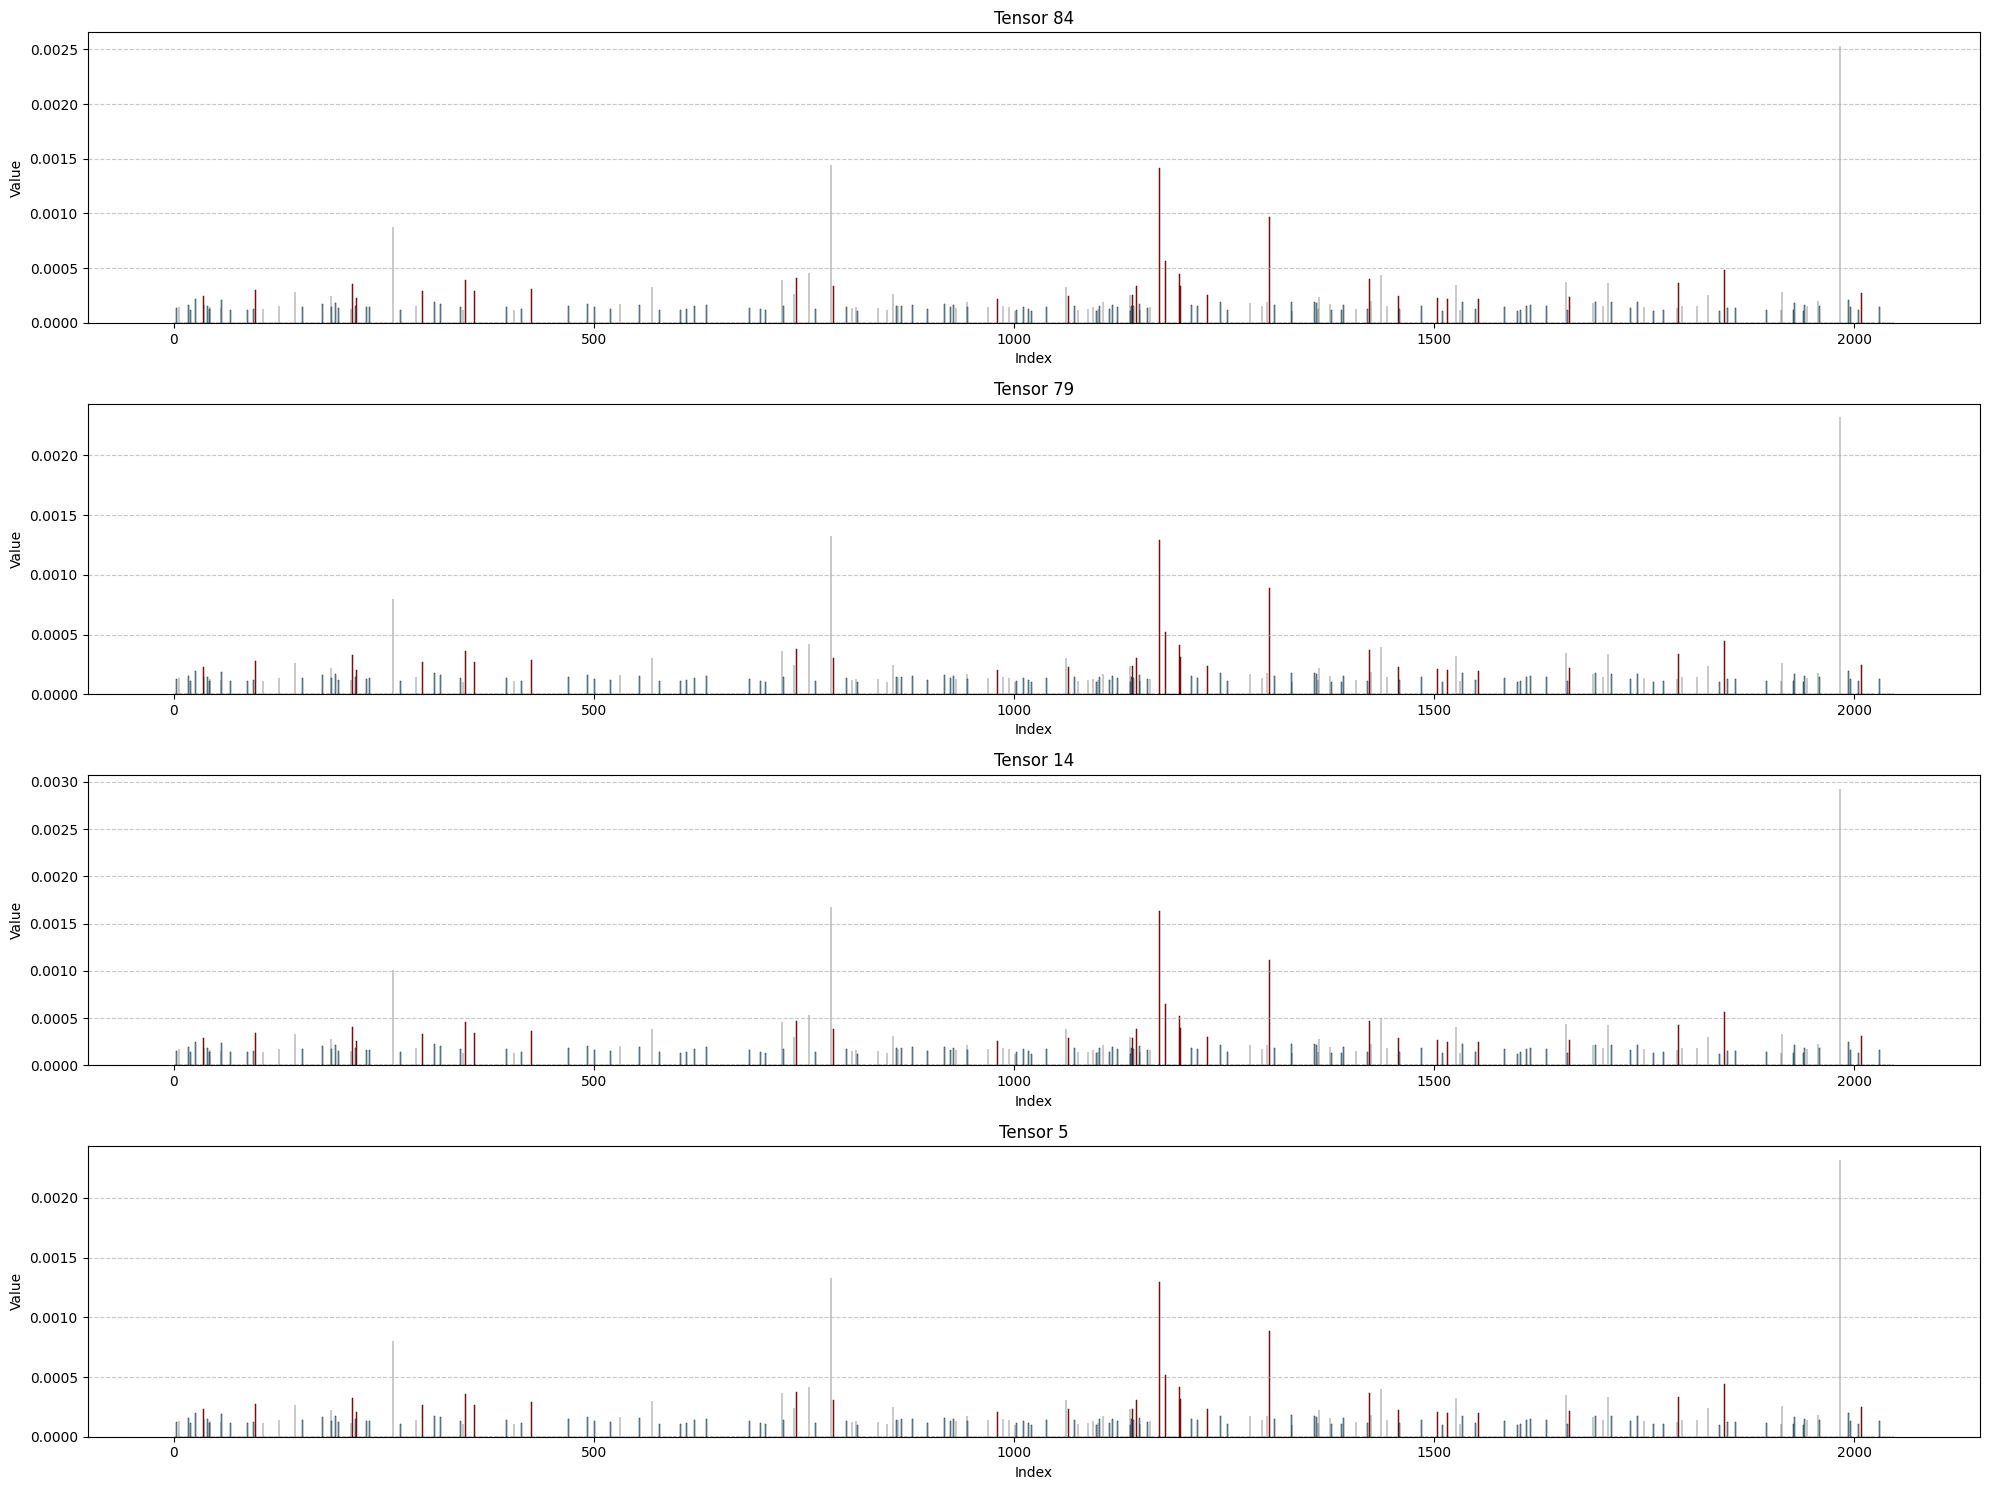

成功可视化了 4 个张量。


True

In [10]:
#n02105505 匈牙利牧羊犬 weights
visualize_multiple_tensors(selected_weights_list1)

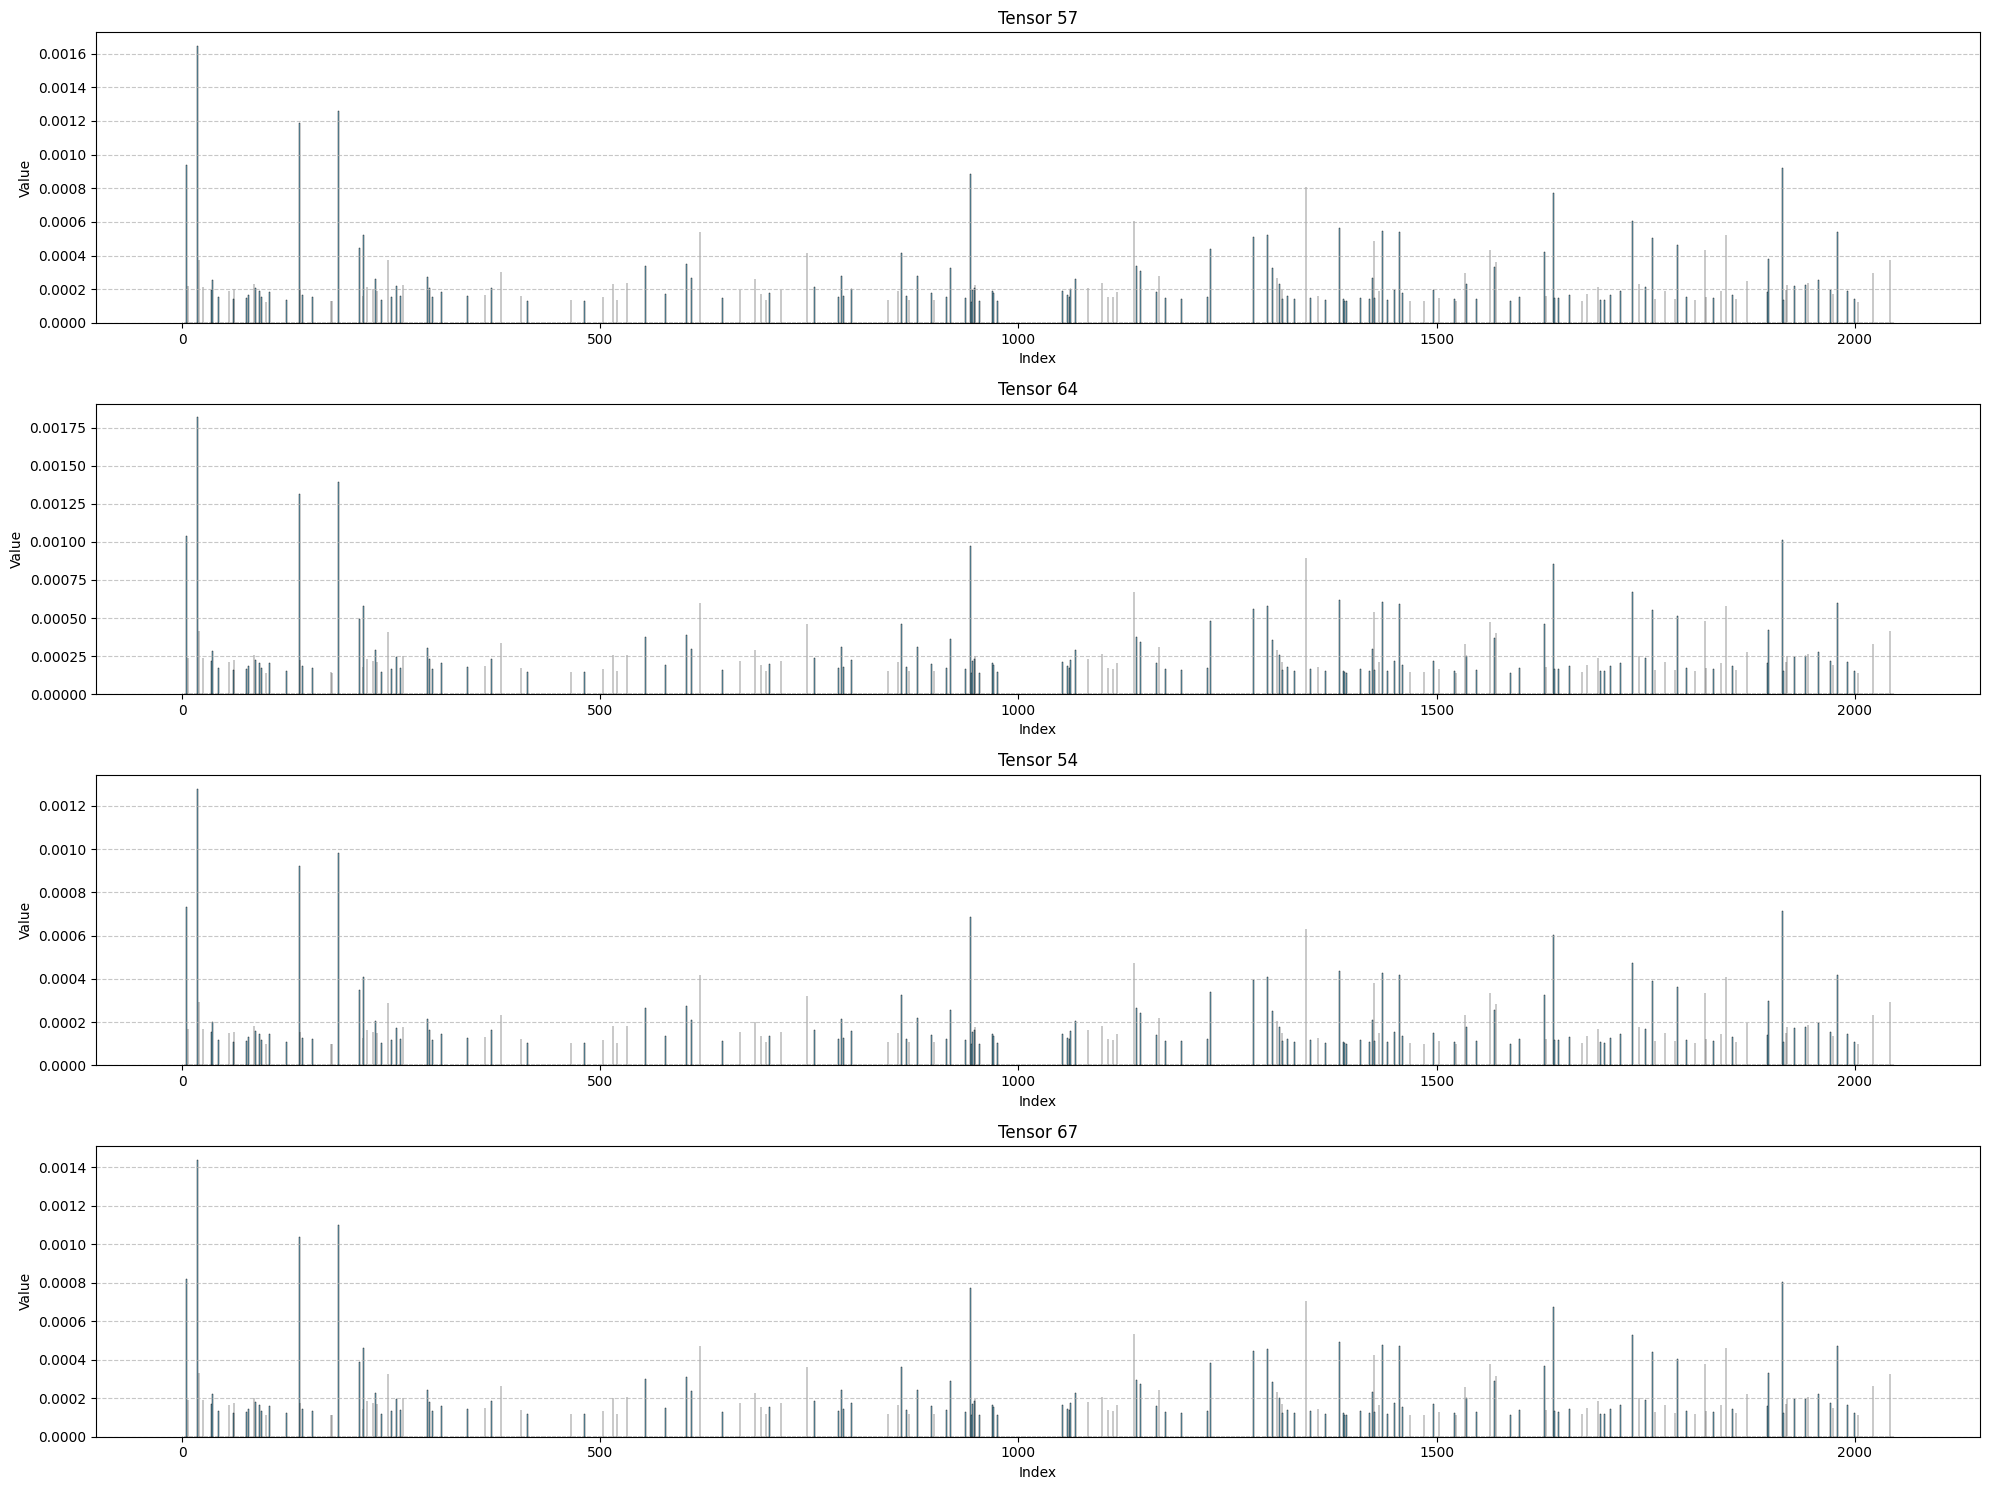

成功可视化了 4 个张量。


True

In [12]:
#n02101006 戈登雪达犬 weights
visualize_multiple_tensors(selected_weights_list2)